In [ ]:
from dotenv import load_dotenv

load_dotenv("../../../config/.env")

True

In [13]:
from langchain.chat_models import init_chat_model
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
vector_store = InMemoryVectorStore(embeddings)

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [14]:
import bs4
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        ),
    ),
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(documents=all_splits)

In [31]:
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """检索与查询相关的信息。"""
    retrieve_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieve_docs
    )
    return serialized, retrieve_docs

def query_or_respond(state: MessagesState):
    """生成用于检索的工具调用或进行响应。"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """生成回答。"""
    # 生成工具消息
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        # 非工具消息之前的上次可能是其他问题，而非本次提问的关联问题，因此只取到最后几个连续的工具消息
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "你是一个用于问答任务的助手。"
        "使用以下检索到的上下文片段来回答问题。"
        "如果你不知道答案，就说你不知道。"
        "回答最多用三句话，并且要简洁。"
        "\n\n"
        # 防御性编程，确保都转为字符串
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("system", "human")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages
    response = llm.invoke(prompt)
    return {"messages": [response]}

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)
graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


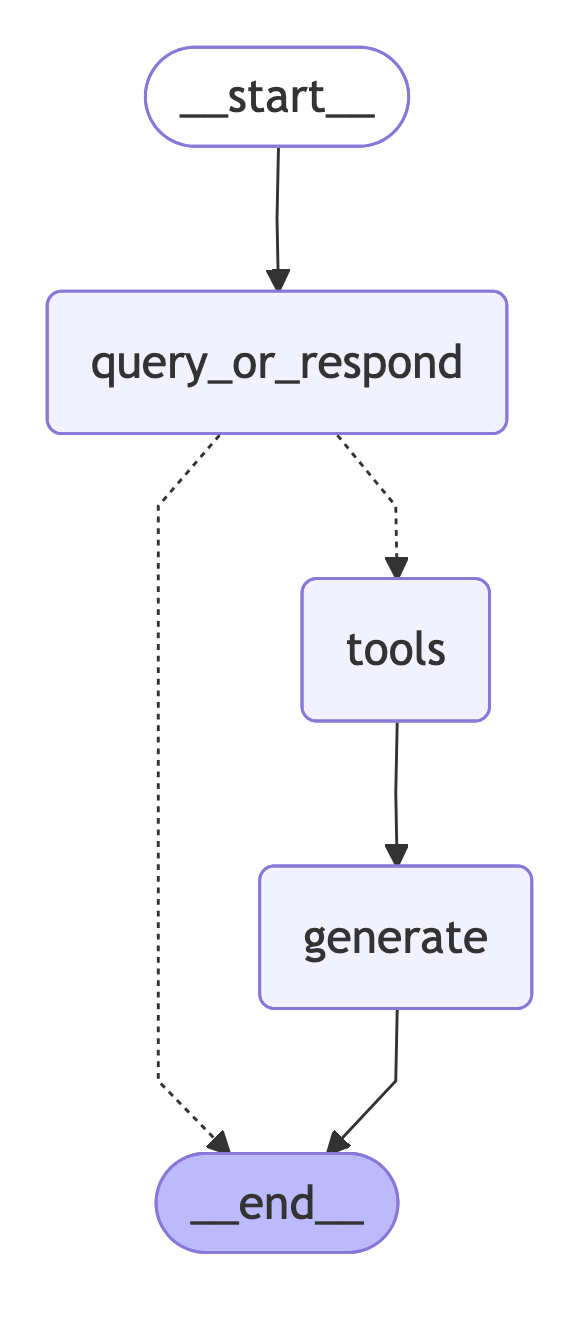

In [32]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [27]:
input_message = "你好"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

你好
================================== Ai Message ==================================

你好！我是一个AI助手，很高兴为您服务。我可以帮您检索信息、回答问题或协助处理各种任务。

请告诉我您需要什么帮助？


In [28]:
input_message = "什么是任务拆分？"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

什么是任务拆分？
================================== Ai Message ==================================

我来帮您查询关于任务拆分的相关信息。
Tool Calls:
  retrieve (call_00_4j5yyqiAzyreBIWwUnp8NwdN)
 Call ID: call_00_4j5yyqiAzyreBIWwUnp8NwdN
  Args:
    query: 任务拆分 task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate inte

In [33]:
from langgraph.checkpoint.memory import MemorySaver

config = {"configurable": {"thread_id": "1"}}
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

input_message = "什么是任务拆解？"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

什么是任务拆解？
================================== Ai Message ==================================

我来为您查询关于任务拆解的相关信息。
Tool Calls:
  retrieve (call_00_JiUM1Zx4aJPqbE6FHHrxFTkx)
 Call ID: call_00_JiUM1Zx4aJPqbE6FHHrxFTkx
  Args:
    query: 任务拆解 任务分解 任务分观念
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to

In [34]:
input_message = "你能查一下做这件事的一些常见方法吗？"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

你能查一下做这件事的一些常见方法吗？
================================== Ai Message ==================================

我来为您查询任务拆解的常见方法。
Tool Calls:
  retrieve (call_00_lGIWBTSjssT1tBBF10uQET25)
 Call ID: call_00_lGIWBTSjssT1tBBF10uQET25
  Args:
    query: 任务拆解方法 任务分解技巧 常见方法
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate i

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


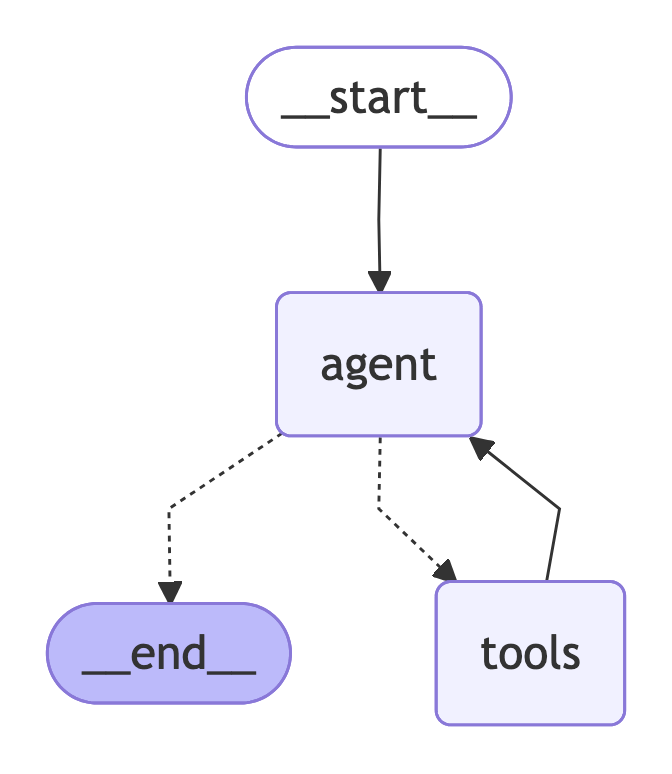

In [36]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

display(Image(agent_executor.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [38]:
config = {"configurable": {"thread_id": "2"}}
input_message = (
    "任务分解的标准方法是什么？\n\n"
    "一旦你得到答案，就去查找该方法的常见扩展形式。"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

任务分解的标准方法是什么？

一旦你得到答案，就去查找该方法的常见扩展形式。
================================== Ai Message ==================================

我来帮您查找任务分解的标准方法及其常见扩展形式。
Tool Calls:
  retrieve (call_00_l9PiYBfehO4JFQK0Zr3Q7t9P)
 Call ID: call_00_l9PiYBfehO4JFQK0Zr3Q7t9P
  Args:
    query: 任务分解的标准方法
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) a